In [152]:
import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

assert pyro.__version__.startswith('1.8.0')
pyro.set_rng_seed(0)

import os
from collections import defaultdict
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDiscreteParallel, AutoNormal, AutoDelta, AutoGuideList, AutoStructured
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete, Importance, EmpiricalMarginal

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.0')

In [153]:
import skbio 
import numpy as np

In [154]:
# input 
fref_in='../../test_data/5VirusMix_3/ref.fasta'
freads_in='../../test_data/5VirusMix_3/all.fasta'

fref_in='../../test_data/super_small_ex/ref.fasta'
freads_in='../../test_data/super_small_ex/seqs.fasta'

In [155]:
def seq_mapping(seq, alphabet):
    # Coding scheme
    # 0:A, 1:C, 2:G, 3:T 4:- (NOT YET:, 5:N)
    mapped = []
    for base in seq:
            mapped.append(alphabet.find(base))
    return torch.tensor(mapped)

def fasta2ref(fref_in, alphabet):
    # Coding scheme
    # 0:A, 1:C, 2:G, 3:T 4:- (NOT YET:, 5:N)
    for seq in skbio.io.read(fref_in, format='fasta'):
        ref = seq_mapping(str(seq), alphabet)
        print('ref ',seq)
    return ref

def fasta2reads(freads_in, alphabet):
    # Coding scheme
    # 0:A, 1:C, 2:G, 3:T 4:- (NOT YET:, 5:N)
    print('reads')
    reads_mapped = []
    for seq in skbio.io.read(freads_in, format='fasta'):
        reads_mapped.append(seq_mapping(str(seq), alphabet))
        print(seq)
    return torch.stack(reads_mapped)

In [156]:
alphabet ='ACGT-'
B = len(alphabet) # size alphabet

# Coding scheme
# 0:A, 1:C, 2:G, 3:T 4:-, 5:N

ref = fasta2ref(fref_in, alphabet)
reads = fasta2reads(freads_in, alphabet) # what about non-unique reads ? 

L=ref.shape[0] # length of genome
N=reads.shape[0] # number of reads

ref  GTTGAGT
reads
GTAAAGT
GTTGAGT
GTTGAGT
GTTGAGT
GTTTAGT
GTTTAGT
GTTTAGT


In [157]:
def get_gamma_weight(reference, gamma, B, L):
    # haplotype of the form: (1,0,2,2,3,4)
    weight_all =[]
    weight = np.full((L,B),(1-gamma)/(B-1))
    np.put_along_axis(weight, reference.detach().cpu().numpy().reshape(L,1), gamma,axis=1)  
    return torch.tensor(weight)

'''
Not needed anymore
def get_theta_weight(haplotype, assignments,theta,B, N, L):
    # haplotype of the form: (1,0,2,2,3,4)
    
    weight = np.full((N,L,B),(1-theta)/(B-1))
    hap_temp = haplotype.detach().cpu().numpy()
    assign_temp = assignments.detach().cpu().numpy()
    hap_ass = hap_temp[assign_temp]
    np.put_along_axis(weight, hap_ass.reshape(N,L,1), theta,axis=0)  
    
    return torch.tensor(weight)
'''
'''
# trying to build get_theta_weight in torch 
hap = torch.tensor([[1,4,2,1],[2,0,1,2]])
z = torch.tensor([0,1,1])
weight_theta = torch.tensor(np.full((3,4,B),(1-theta)/(B-1)))
src = theta*torch.ones((3,4,1), dtype=torch.float64)
# here it is 
weight_theta.scatter_(2, hap[z].reshape(3,4,1), src)
'''

'\n# trying to build get_theta_weight in torch \nhap = torch.tensor([[1,4,2,1],[2,0,1,2]])\nz = torch.tensor([0,1,1])\nweight_theta = torch.tensor(np.full((3,4,B),(1-theta)/(B-1)))\nsrc = theta*torch.ones((3,4,1), dtype=torch.float64)\n# here it is \nweight_theta.scatter_(2, hap[z].reshape(3,4,1), src)\n'

### Simplyfied model with fixed hyperparameters

ref = reference sequence  
$N$ = number of reads  
$K$ = number of clusters/components  
$L$ = genome length (number of positions)
alphabet = {A, C, G, T, -}

Fixed parameters: 
* mutation rate: $1- \gamma$
* error rate: $1-\theta$
* Dirichlet prior: $\alpha = (\alpha_1, ..., \alpha_k)$

Cluster weights ($K$-dim): $\pi | \alpha \sim Dir(\alpha)$  
Cluster assignments ($N$-dim): $z_n|\pi \sim Categorical(\pi)$  
Cluster centers/haplotypes ($K$x$L$-dim): $h_{kl} | ref, \gamma \sim Categorical(W) $ 
with $W(l,i)=
\begin{cases} 
\gamma,  \text{ if }i = ref[l] \\
\frac{1-\gamma}{4}, \text{ else. }
\end{cases}$ for $l \in {1, ..., L}$ and $i\in {1,..., |alphabet|}$  
Likelihood of the reads ($N$-dim): $r | z, h, \theta \sim Categorical(E)$ 
with $E(n,l,i)=
\begin{cases} 
\theta,  \text{ if }i = h_{z_n}[l] \\
\frac{1-\theta}{4}, \text{ else. }
\end{cases}$ for $n \in {1, ..., N}$, $l \in {1, ..., L}$ and $i\in {1,..., |alphabet|}$  



In [159]:
K = 10  # Fixed number of components

# fixed constants
gamma = 0.70
theta = 0.99    


L = ref.shape[0] # length of genome
N = reads.shape[0] # number of reads
B = len(alphabet)
ref_gamma_weight = get_gamma_weight(ref, gamma, B, L).expand(K,-1,-1) #KxLxB


print('N ', N)
print('L ', L)
print('B ', B)

@config_enumerate
def model(reads): # reads is N x L dimensional 
    print('-------')
    
    # hyperparameter
    alpha = torch.ones(K)/K
    
    #cluster weights/concentrations
    pi = pyro.sample('pi', dist.Dirichlet(alpha))
    print(pi)
    print(pi.sum())
    
    genome_axis = pyro.plate('genome_axis', L, dim=-1)
    
    with pyro.plate('haplo_axis', K, dim=-2):
        with genome_axis:
            #h = pyro.sample('h', dist.Categorical(ref_gamma_weight)) # KxL 
            h = pyro.sample('h', dist.Categorical(ref_gamma_weight))
            
    with pyro.plate('read_axis', N,dim=-2):
        # cluster assignment 
        z = pyro.sample('z', dist.Categorical(pi))
        print('h ', h.shape)
        print('z ',z.shape)
        #print('z ', z)
        #print('h ', h)
        #print('h[z] ',h[z])
        with genome_axis:
            # read weight -> NxLxB
            weight_theta = torch.tensor(np.full((N,L,B),(1-theta)/(B-1)))
            read_weight = weight_theta.scatter_(2, h[z].reshape(N,L,1), theta*torch.ones((N,L,1), dtype=torch.float64))
            pyro.sample('obs', dist.Categorical(read_weight), obs=reads) # N x L dimensional 
    
    return pi, z, h
    

N  7
L  7
B  5


In [160]:
# Importance sampling 
importance = Importance(model, guide=None, num_samples=3)
print("doing importance sampling...")
emp_marginal = EmpiricalMarginal(importance.run(reads))

doing importance sampling...
-------
tensor([2.0283e-15, 3.2838e-05, 2.4022e-01, 3.3086e-02, 1.9855e-02, 9.0192e-03,
        1.0431e-04, 6.4160e-01, 5.6075e-02, 3.1236e-06])
tensor(1.)
h  torch.Size([10, 7])
z  torch.Size([7, 1])
-------
tensor([2.0283e-15, 3.2838e-05, 2.4022e-01, 3.3086e-02, 1.9855e-02, 9.0192e-03,
        1.0431e-04, 6.4160e-01, 5.6075e-02, 3.1236e-06])
tensor(1.)
h  torch.Size([10, 7])
z  torch.Size([7, 1])
-------
tensor([2.2689e-16, 6.2411e-04, 7.0364e-02, 8.6950e-04, 4.7148e-03, 3.4949e-10,
        4.4631e-11, 6.4776e-01, 2.3657e-01, 3.9100e-02])
tensor(1.)
h  torch.Size([10, 7])
z  torch.Size([7, 1])
-------
tensor([2.2689e-16, 6.2411e-04, 7.0364e-02, 8.6950e-04, 4.7148e-03, 3.4949e-10,
        4.4631e-11, 6.4776e-01, 2.3657e-01, 3.9100e-02])
tensor(1.)
h  torch.Size([10, 7])
z  torch.Size([7, 1])
-------
tensor([3.9566e-02, 2.3747e-18, 1.4858e-01, 7.7087e-01, 1.7479e-06, 2.5996e-08,
        3.4370e-05, 8.1457e-03, 2.2815e-05, 3.2782e-02])
tensor(1.)
h  torch.Si

TypeError: expected Tensor as element 0 in argument 0, but got tuple

In [161]:
# this shows the problem that with enumerate the discrete variables are integrated out

def guide(reads):
    pass

pyro.clear_param_store()
print("Sampling:")
model(reads)
print("Enumerated Inference:")
elbo = TraceEnum_ELBO(max_plate_nesting=0)
elbo.loss(model, guide);


Sampling:


TypeError: model() missing 1 required positional argument: 'reads'

In [45]:
print(poutine.trace(model).get_trace(reads).format_shapes())

   Trace Shapes:           
    Param Sites:           
   Sample Sites:           
         pi dist       | 10
           value       | 10
genome_axis dist       |   
           value     5 |   
 haplo_axis dist       |   
           value    10 |   
          h dist 10  5 |   
           value 10  5 |   
  read_axis dist       |   
           value     7 |   
          z dist  7  1 |   
           value  7  1 |   
        obs dist  7  5 |   
           value  7  5 |   


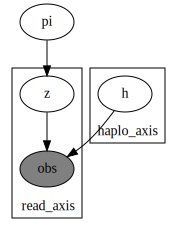

In [69]:
pyro.render_model(model, model_args=(reads,))

In [ ]:
# Get further info about the variables in the model
# https://linuxtut.com/en/b40c946bd779e5fc0b9a/ 
trace_model = poutine.trace(model).get_trace(reads)
tuple(trace_model.nodes.keys())
trace_model.nodes['h']

In [ ]:
# define the guide myself

def guide_lara(reads):
    
    alpha_up = pyro.param('alpha_up', 1/K * torch.ones(K), constraint=constraints.simplex)
    ref_gamma_weight_up = pyro.param('ref_gamma_weight_up',ref_gamma_weight, constraint=constraints.positive)
    
    pi = pyro.sample('pi', dist.Dirichlet(alpha_up))
    genome_axis = pyro.plate('genome_axis', L, dim=-1)
    with pyro.plate('haplo_axis', K, dim=-2):
        with genome_axis:
            #h = pyro.sample('h', dist.Categorical(ref_gamma_weight_up), infer={'enumerate': 'parallel'})
            h = pyro.sample('h', dist.Categorical(ref_gamma_weight_up))
    
    with pyro.plate('read_axis', N,dim=-2):
        z = pyro.sample('z', dist.Categorical(pi))

In [147]:
'''
## NUTS cannot be used as it marginalizes out the discrete variables -- we need them explicitly as they dictate 
## the proba table for the likelihood. 

from pyro.infer.mcmc import NUTS, MCMC
from jax import random

rng_key = random.PRNGKey(0)
num_warmup, num_samples = 10, 100

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples, num_chains=1)

mcmc.run(reads)

mcmc.summary()
#mcmc.diagnostics()

'''

'\n## NUTS cannot be used as it marginalizes out the discrete variables -- we need them explicitly as they dictate \n## the proba table for the likelihood. \n\nfrom pyro.infer.mcmc import NUTS, MCMC\nfrom jax import random\n\nrng_key = random.PRNGKey(0)\nnum_warmup, num_samples = 10, 100\n\nkernel = NUTS(model)\nmcmc = MCMC(kernel, num_warmup, num_samples, num_chains=1)\n\nmcmc.run(reads)\n\nmcmc.summary()\n#mcmc.diagnostics()\n\n'

In [149]:
# This guide set up works (sometimes) -- but is not really clustering 
guide = AutoGuideList(model)
guide.append(AutoDelta(poutine.block(model, hide=["h","z"])))
guide.append(AutoDiscreteParallel(poutine.block(model, hide=['pi'])))

optim = Adam({"lr": 0.05})
elbo = Trace_ELBO()
svi = SVI(model, guide, optim, loss= Trace_ELBO())
losses = []

n_steps = 1000

for step in range(n_steps):
    loss = svi.step(reads)
    losses.append(loss)

-------
tensor([2.0011e-04, 1.2508e-01, 5.4234e-04, 6.5831e-01, 1.4794e-08, 6.6579e-03,
        2.2314e-11, 1.7843e-06, 3.5285e-02, 1.7392e-01])
tensor(1.)
h  torch.Size([10, 7])
z  torch.Size([7, 1])
-------
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])
tensor(1.0000)
h  torch.Size([10, 7])
z  torch.Size([7, 1])
-------
tensor([2.8096e-01, 2.6265e-04, 8.2359e-05, 6.6660e-01, 1.7847e-07, 3.2663e-08,
        5.6545e-03, 1.0315e-25, 1.1910e-04, 4.6320e-02])
tensor(1.0000)
h  torch.Size([10, 7])
z  torch.Size([7, 1])
-------
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       grad_fn=<ExpandBackward0>)
tensor(nan, grad_fn=<SumBackward0>)


ValueError: Expected parameter probs (Tensor of shape (10,)) of distribution Categorical(probs: torch.Size([10])) to satisfy the constraint Simplex(), but found invalid values:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       grad_fn=<DivBackward0>)
   Trace Shapes:           
    Param Sites:           
   Sample Sites:           
         pi dist       | 10
           value       | 10
genome_axis dist       |   
           value     7 |   
 haplo_axis dist       |   
           value    10 |   
          h dist 10  7 |   
           value 10  7 |   
  read_axis dist       |   
           value     7 |   

In [ ]:
estimates = guide(reads)

In [ ]:
estimates

In [ ]:
trace_guide_map = poutine.trace(guide).get_trace(reads)
model_map = poutine.replay(model, trace=trace_guide_map)

In [ ]:
trace_model_map = poutine.trace(model_map).get_trace(reads)
trace_guide_map.nodes

In [ ]:
model_map = infer_discrete(model_map, first_available_dim=-2)
trace_model_map = poutine.trace(model_map).get_trace(reads)

In [148]:
def convert_h_to_sed(h, alphabet):
    '''
    Print the reconstructed haplotypes
    '''
    for k in range(h.shape[0]):
        seq=[]
        for base in h[k]:
            seq.append(alphabet[base])
        print(''.join(seq))

In [ ]:
# get reconstructed haplos
convert_h_to_sed(estimates['h'], alphabet)

In [ ]:
# plot loss
elbo_plot = plt.figure(figsize=(15, 5))

elbo_ax = elbo_plot.add_subplot(1, 2, 1)
elbo_ax.set_title("ELBO Value vs. Iteration Number for Pyro BBVI on Sunspot Data")
elbo_ax.set_ylabel("ELBO")
elbo_ax.set_xlabel("Iteration Number")
elbo_ax.plot(np.arange(n_steps), losses)

autocorr_ax = elbo_plot.add_subplot(1, 2, 2)
autocorr_ax.acorr(np.asarray(losses), detrend=lambda x: x - x.mean(), maxlags=750, usevlines=False, marker=',')
autocorr_ax.set_xlim(0, 500)
autocorr_ax.axhline(0, ls="--", c="k", lw=1)
autocorr_ax.set_title("Autocorrelation of ELBO vs. Lag for Pyro BBVI on Sunspot Data")
autocorr_ax.set_xlabel("Lag")
autocorr_ax.set_ylabel("Autocorrelation")
elbo_plot.tight_layout()
plt.show()